In [1]:
import os
from operator import itemgetter    
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
#from sklearn.utils.fixes import signature
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


import tensorflow as tf
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Activation, LSTM, GRU, SpatialDropout1D, Flatten
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.datasets import reuters

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cb_EarlyStopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
cb_ModelCheckpoint = ModelCheckpoint(filepath='model.best.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
cb_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, mode='max', min_lr=0.00000001)

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


In [4]:
print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)
print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)

train_data  (8982,)
train_labels  (8982,)
test_data  (2246,)
test_labels  (2246,)


In [5]:
# Заменим числа в тренировочном датасете, чтобы видеть слова
# Заметинм, что индекс начинаются с 3, потому что 0,1,2 являются специальными для отступа, начала последовательности и неизвестного символа. 

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

print(train_data[0])
print(decoded_newswire)
print(train_labels[0])

557056/550378 [==============================] - 0s 0us/step
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
3


In [6]:
#Векторизация функция
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [7]:
# Векторизация и нормализация тренировочного и тестового датасетов

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (8982, 10000)
x_test  (2246, 10000)


In [8]:
# Векторизация меток
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print("one_hot_train_labels ", one_hot_train_labels.shape)
print("one_hot_test_labels ", one_hot_test_labels.shape)

one_hot_train_labels  (8982, 46)
one_hot_test_labels  (2246, 46)


In [9]:
# Задание валидационной выборки

x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

print("x_val ", x_val.shape)
print("y_val ", y_val.shape)

print("partial_x_train ", partial_x_train.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (1000, 10000)
y_val  (1000, 46)
partial_x_train  (7982, 10000)
partial_y_train  (7982, 46)


In [11]:
# Модель сети
# Dropout слои помогают решить проблему преобучения

model = models.Sequential()
model.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(46, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 46)               

In [12]:
# Обучение модели

NumEpochs = 10
BatchSize = 128

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, 
                    epochs=NumEpochs, 
                    batch_size=BatchSize, 
                    callbacks = [cb_EarlyStopping, cb_ModelCheckpoint, cb_ReduceLROnPlateau],
                    validation_split=0.1, #validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(x_val, y_val)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)

history_dict = history.history
history_dict.keys()

Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 12.8844 - accuracy: 0.5084
Epoch 00001: val_accuracy improved from -inf to 0.59825, saving model to model.best.hdf5
57/57 [==============================] - 8s 146ms/step - loss: 12.8844 - accuracy: 0.5084 - val_loss: 6.5304 - val_accuracy: 0.5982
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 5.7485 - accuracy: 0.5718
Epoch 00002: val_accuracy did not improve from 0.59825
57/57 [==============================] - 8s 136ms/step - loss: 5.7485 - accuracy: 0.5718 - val_loss: 5.2613 - val_accuracy: 0.5970
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 4.9920 - accuracy: 0.5942
Epoch 00003: val_accuracy did not improve from 0.59825
57/57 [==============================] - 7s 124ms/step - loss: 4.9920 - accuracy: 0.5942 - val_loss: 4.8477 - val_accuracy: 0.5857
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 4.7140 - accuracy: 0.6181
Epoch 00004: val_accuracy impr

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

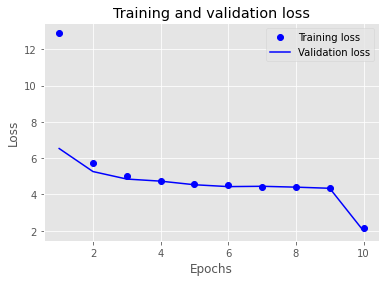

In [13]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

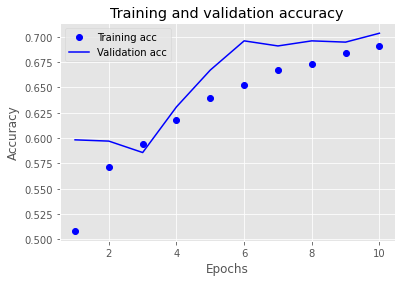

In [14]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
# Прогноз

predictions = model.predict(x_test)
# Каждый прогноз это вектор из 46 коэффициентов
print(predictions[123].shape)

# Сумма уоэффициентов должна быть равна единице
print(np.sum(predictions[123]))

# Наксимальный коэффициент соответствует предсказанному классу
print(np.argmax(predictions[123]))

(46,)
0.99999994
4


In [16]:
# Получим 3 наиболее предсказываемых класса
predictions[21].argsort()[-3:][::-1]

array([ 3,  4, 16])

In [17]:
test_labels[21]

3

In [18]:
SampleNum = 2125

print(test_labels[SampleNum])
print(predictions[SampleNum].argsort()[-3:][::-1])

test_labels[SampleNum] in predictions[SampleNum].argsort()[-3:][::-1]

6
[ 4  3 19]


False

In [19]:
Top3Preds = np.zeros((2246,3), dtype=int)
print(Top3Preds.shape)

for SampleNum in range(predictions.shape[0]):
    Top3Preds[SampleNum] = predictions[SampleNum].argsort()[-3:][::-1]
    
Top3Preds

(2246, 3)


array([[ 3,  4, 20],
       [ 1, 16, 13],
       [ 1, 16, 13],
       ...,
       [ 3,  4, 20],
       [ 3,  4, 16],
       [ 1, 11, 16]])

In [20]:

FinalPreds = np.zeros((2246,1), dtype=int)
print(FinalPreds.shape)

for SampleNum in range(Top3Preds.shape[0]):
    if test_labels[SampleNum] in Top3Preds[SampleNum]:
        FinalPreds[SampleNum] = 1
        
FinalPreds

(2246, 1)


array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [21]:
FinalPreds = pd.DataFrame(FinalPreds)
NumTop3 = FinalPreds[0][FinalPreds[0] == 1].count()
percentTop3 = round(100 *NumTop3 / FinalPreds.shape[0], 1)

print('Percent of one from top 3 being correct ... ', percentTop3, '%')

Percent of one from top 3 being correct ...  77.2 %
